The goal here is to evaluate the errors introduced adversarial training by a bit-wise comparison of the original weight values with the modified values.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
origWeights = np.load('origWeights.npy')
modifiedWeights = np.load('modifiedWeights.npy')
origBiases = np.load('origBiases.npy')
modifiedBiases = np.load('modifiedBiases.npy')

In [3]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [4]:
def scale_weights(listArrays, scaleFunc):
    '''
    scale the values in a list of arrays based on scaleFunc
    '''
    scaledListArrays = []
    for arr in listArrays:
        scaledArray = scaleFunc(arr)
        scaledListArrays.append(scaledArray)
    return scaledListArrays

In [5]:
def convert_toBinary(decFrac, res):
    '''
    Implements the standard algorithm used to convert a decimal 
    fraction into binary.
    Accepts a decimal value between 0 and 1 and returns a list of 
    0s and 1s corresponding to its binary representation.
    'res' represents the bit resolution and determines the length of
    the list.
    '''
    binRep = []
    for i in range(res):
        decFrac = decFrac * 2
        binRep.append(int(decFrac))
        if int(decFrac) == 1:
            decFrac -= 1
    return binRep

In [6]:
def convert_seqToBinary(listArrays, res):
    '''
    For each array in the input, the output contains a list of 
    binary representations corresponding to the array elements.
    The shape of the original array is not preserved. 
    '''
    binListArrays = []
    for arr in listArrays:
        binArray = []
        for val in np.nditer(arr):
            binArray.append(convert_toBinary(val, res))
        binListArrays.append(binArray)
    return binListArrays

In [7]:
def convert_toFraction(origValues, modifiedValues):
    '''
    computes the min and max considering all input values, 
    and maps all the values into [0-1)
    '''
    # Both original as well as modified vlaues are considered while 
    # finding the minimum and maximum; this ensures that all values 
    # are between 0 and 1
    origMin, origMax = compute_minAndMax(origValues)
    modifiedMin, modifiedMax = compute_minAndMax(modifiedValues)
    minThres = min(origMin, modifiedMin)
    # Since we don't want to map any of the values to 1, maxThres 
    # is set to be slightly larger than the maximum.
    maxThres = max(origMax, modifiedMax) + 1e-5
    # scaleFunc is an anaonymous function that computes the mapping
    scaleFunc = lambda x : (x - minThres)/(maxThres - minThres)
    scaledOrigValues = scale_weights(origValues, scaleFunc)
    scaledModifiedValues = scale_weights(modifiedValues, scaleFunc)
    return scaledOrigValues, scaledModifiedValues

def compute_bitErrorRate(scaledOrigWeights, scaledModifiedWeights, res):
    '''
    Takes original and modified values in [0-1) as input, and 
    computes BER by comparing their binary representations
    '''
    binOrigWeights = convert_seqToBinary(scaledOrigWeights, res)
    binModifiedWeights = convert_seqToBinary(scaledModifiedWeights, res)
    # Once the values are converted into binary, we want to iterate 
    # through the lists to compare the bit values in the original and 
    # modified arrays.
    numLayers = len(scaledOrigWeights)
    numBitErrors = np.zeros((numLayers, res), np.uint32)
    numBitVals = np.zeros((numLayers, res), np.uint32)
    for layerNo, (binOrigWeightsLayer, binModifiedWeightsLayer
                 ) in enumerate(zip(binOrigWeights, binModifiedWeights)):
        for binOrigWeight, binModifiedWeight in zip(
            binOrigWeightsLayer, binModifiedWeightsLayer):
            for bitPos, (origBit, modifiedBit
                        ) in enumerate(zip(binOrigWeight, binModifiedWeight)):
                numBitVals[layerNo][bitPos] += 1
                if origBit != modifiedBit:
                    numBitErrors[layerNo][bitPos] += 1
    bitErrorRates = numBitErrors/numBitVals
    return bitErrorRates

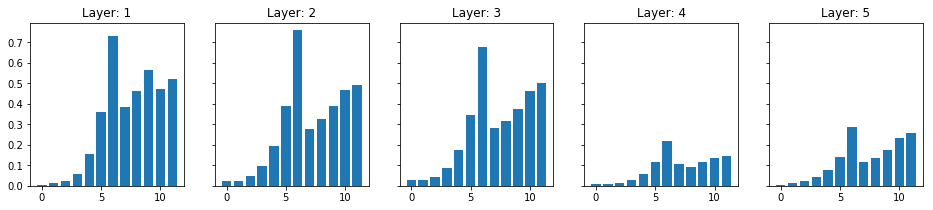

In [8]:
BIT_RESOLUTION = 12
# First, scale the weights into [0,1)
scaledOrigWeights, scaledModifiedWeights = convert_toFraction(
    origWeights, modifiedWeights)
# scaled_origWeights and scaled_modifiedWeights are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigWeights, scaledModifiedWeights, BIT_RESOLUTION)
numLayers = len(origWeights)
f, axarr = plt.subplots(1,numLayers, sharey=True, figsize=(16,3))
for layerNo in range(numLayers):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))

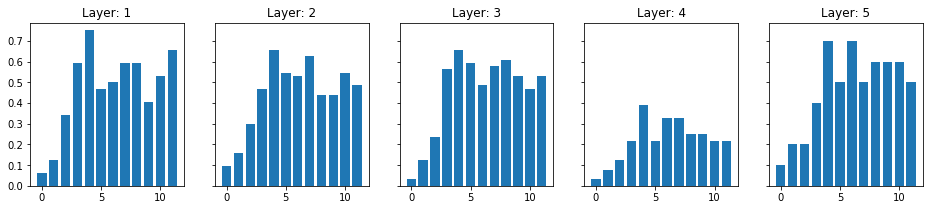

In [9]:
# First, scale the Biases into [0,1)
scaledOrigBiases, scaledModifiedBiases = convert_toFraction(
    origBiases, modifiedBiases)
# scaled_origBiases and scaled_modifiedBiases are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigBiases, scaledModifiedBiases, BIT_RESOLUTION)
f, axarr = plt.subplots(1,numLayers, sharey=True, figsize=(16,3))
for layerNo in range(numLayers):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))

In [10]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [11]:
modelNoise = measure_noise(origWeights, modifiedWeights)

In [12]:
# generate random noise
randNoise = []
for modLayerNoise in modelNoise:
    mu = modLayerNoise.mean()
    sigma = modLayerNoise.std()
    randLayerNoise = np.random.normal(mu, sigma, modLayerNoise.shape)
    randNoise.append(randLayerNoise)

In [13]:
# generate randomly perturbed weights
randModifiedWeights = []
for origArr, noiseArr in zip(origWeights, randNoise):
    randModifiedArr = origArr - noiseArr
    randModifiedWeights.append(randModifiedArr)

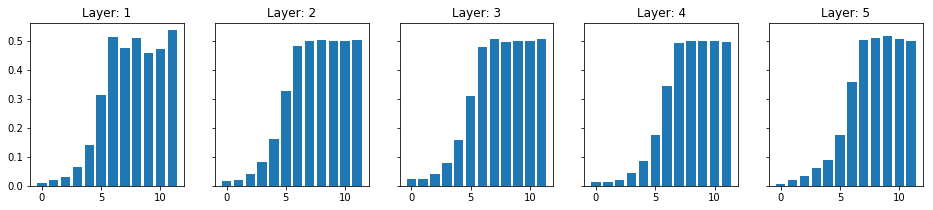

In [14]:
# First, scale the weights into [0,1)
scaledOrigWeights, scaledModifiedWeights = convert_toFraction(
    origWeights, randModifiedWeights)
# scaled_origWeights and scaled_modifiedWeights are in [0-1), and we want
# to convert them into binary.
ber = compute_bitErrorRate(
    scaledOrigWeights, scaledModifiedWeights, BIT_RESOLUTION)
numLayers = len(origWeights)
f, axarr = plt.subplots(1,numLayers, sharey=True, figsize=(16,3))
for layerNo in range(numLayers):
    axarr[layerNo].bar(np.arange(BIT_RESOLUTION), ber[layerNo])
    axarr[layerNo].set_title('Layer: ' + str(layerNo+1))